# MLIP hackathon starter notebook

In this challenge, we train a Machine Learning Interatomic Potential (MLIP) model using the [`mlip`](https://github.com/instadeepai/mlip) library.

If you run this on Google Colab, make sure to select a GPU runtime (Runtime > Change runtime type > Hardware accelerator > GPU).

In [92]:
!pip install mlip "jax[cuda12]"

**Install, required imports, and logging setup**


In [93]:
import os
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

# For dataset loading
from mlip.data import GraphDatasetBuilder, ExtxyzReader

# For model
from mlip.models import Mace, Nequip, Visnet, ForceField

# For optimizer
import optax

# For loss function
from mlip.models.loss import MSELoss

# For training
from mlip.training import TrainingLoop
from mlip.models.model_io import save_model_to_zip, load_model_from_zip
from mlip.models.params_loading import load_parameters_from_checkpoint

# For checkpointing
from mlip.training import TrainingIOHandler, log_metrics_to_line
from mlip.training.training_io_handler import LogCategory

# Set up logging
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)s - %(message)s')

# Set dedicated logging for mlip. Set this to logging.DEBUG to see more detailed logs.
logging.getLogger("mlip").setLevel(logging.INFO)

Let's also check what device we are using:

In [94]:
import jax

print(jax.devices())

[CudaDevice(id=0)]


## 1. Preparing a dataset

For this example, we train on configurations of a molecule called [3-(benzyloxy)pyridin-2-amine](https://pubchem.ncbi.nlm.nih.gov/substance/854545) (molecular formula `C12H12N2O`, abbreviated as `3BPA`) sampled with Molecular Dynamics at a temperature of 300 Kelvin.

It's molecular structure consists of a **pyridin-2-amine core**:

 * A **pyridine ring** (six-membered aromatic ring with one nitrogen atom).

 * An **amino group (-NH₂)** at the 2-position of the pyridine ring (adjacent to the nitrogen).

Benzyloxy substituent at position 3:

 * A **benzyloxy group (-OCH₂C₆H₅)** is attached to the 3-position of the pyridine ring.

 * This consists of a **methylene bridge (–CH₂–)** bonded to a **phenyl ring (C₆H₅)**, connected via an **ether linkage (–O–)**.

![3BPA](https://go.drugbank.com/structures/DB02352/thumb.svg)

The data processing **is a two step process**:

1. **We read the data from disk into [`ChemicalSystem`](https://instadeepai.github.io/mlip/api_reference/data/chemical_system.html) objects**. This is done by a "reader", and since the dataset is stored in extended xyz format, it can be read with the [`ExtxyzReader`](https://instadeepai.github.io/mlip/api_reference/data/chemical_systems_readers/extxyz_reader.html). The *mlip* library also includes a HDF5 format reader: [`Hdf5Reader`](https://instadeepai.github.io/mlip/api_reference/data/chemical_systems_readers/hdf5_reader.html).

In [95]:
%%bash
mkdir -p data

[ -f data/test_public.xyz ] || wget -P data https://raw.githubusercontent.com/BioGeek/hackathon_IndabaX_2025_mlip/refs/heads/main/data/test_public.xyz
[ -f data/train.xyz ] || wget -P data https://raw.githubusercontent.com/BioGeek/hackathon_IndabaX_2025_mlip/refs/heads/main/data/train.xyz
[ -f data/validation.xyz ] || wget -P data https://raw.githubusercontent.com/BioGeek/hackathon_IndabaX_2025_mlip/refs/heads/main/data/validation.xyz

In [96]:
reader = ExtxyzReader(
    ExtxyzReader.Config(
        train_dataset_paths="data/train.xyz",
        valid_dataset_paths="data/validation.xyz")
)

2. **We process these [`ChemicalSystem`](https://instadeepai.github.io/mlip/api_reference/data/chemical_system.html) objects into graphs.** This process uses the class [`GraphDatasetBuilder`](https://instadeepai.github.io/mlip/api_reference/data/graph_dataset_builder.html) which offers some degree of customisation through its [config class](https://instadeepai.github.io/mlip/api_reference/data/dataset_configs.html#mlip.data.configs.GraphDatasetBuilderConfig).



In [97]:
builder_config = GraphDatasetBuilder.Config(
    graph_cutoff_angstrom=5.0,
    batch_size=16,
)

builder = GraphDatasetBuilder(reader, builder_config)
builder.prepare_datasets() # This step is required to compute all dataset information (used later on by most MLIP model)

train_set, validation_set, _ = builder.get_splits()

Graph creation:   0%|          | 0/500 [00:00<?, ?it/s]

valid graph creation:   0%|          | 0/100 [00:00<?, ?it/s]

test graph creation: 0it [00:00, ?it/s]

INFO - Starting to compute mandatory dataset statistics: this may take some time...


Average number of neighbors computation:   0%|          | 0/500 [00:00<?, ?it/s]

INFO - Processed 10% of data
INFO - Processed 20% of data
INFO - Processed 30% of data
INFO - Processed 40% of data
INFO - Processed 50% of data
INFO - Processed 60% of data
INFO - Processed 70% of data
INFO - Processed 80% of data
INFO - Processed 90% of data
INFO - Processed 100% of data


More information can be found in the [deep-dive on data processing](https://instadeepai.github.io/mlip/user_guide/data_processing.html)  in our documentation for more details.

We can now **print some statistics about our dataset** along with the [`DatasetInfo`](https://instadeepai.github.io/mlip/api_reference/data/dataset_info.html) object that will be required for downstream tasks. The **dataset info** holds all the hyperparameters of the models that are directly derived from the dataset or its processing, e.g., the cutoff distance to determine the graph edges.

In [98]:
print("Dataset info:", builder.dataset_info)
print("Number of batches in train set:", len(train_set))
print("Number of batches in validation set:", len(validation_set))

Dataset info: Atomic Energies: {'H': -723.2941604798493, 'C': -723.2941604798525, 'N': -120.54902674664157, 'O': -60.27451337332064}, Avg. num. neighbors: 16.72, Avg. r_min: 1.00, Graph cutoff distance: 5.0
Number of batches in train set: 32
Number of batches in validation set: 7


The atomic energies and forces are stored in the `energy` and `forces` attributes of the [`ChemicalSystem`](https://instadeepai.github.io/mlip/api_reference/data/chemical_system.html) objects, respectively. The energies are in [eV](https://en.wikipedia.org/wiki/Electronvolt), and the forces are in eV/[Å](https://en.wikipedia.org/wiki/Angstrom).

## 2. Preparing a training loop

To start training, we first need to prepare some prerequisites. These are, as for all ML models:
- A **model architecture**,
- An **optimizer**, and
- A **loss function**

We start with the **model architecture**:

We can use one of the pre-defined models in the *mlip* library, such as MACE, NequIP, or ViSNet. These models are designed to handle molecular graphs and can be configured with various hyperparameters.

For this tutorial, we provide the initialization code for MACE, NequIP and ViSnet, but commented out two of them. For all the hyperparameters available, see the documentations of the [MACE config](https://instadeepai.github.io/mlip/api_reference/models/mace.html#mlip.models.mace.config.MaceConfig), the [NequIP config](https://instadeepai.github.io/mlip/api_reference/models/nequip.html#mlip.models.nequip.config.NequipConfig), and the [ViSNet config](https://instadeepai.github.io/mlip/api_reference/models/visnet.html#mlip.models.visnet.config.VisnetConfig).

The model creation process includes two steps:
* 1: the creation of the MLIP network and
* 2:the creation  of the force field.

See our [deep-dive on models](https://instadeepai.github.io/mlip/user_guide/models.html) for a detailed explanation of this pattern.

**Hint**: try some of the other pre-defined models by uncommenting the lines below and running the cell again. You can also try to change some of the hyperparameters in the config classes, e.g., the number of layers or channels

In [99]:
# We override some of the default hyperparameters
# of the model to make it smaller such that this training example becomes more minimal
# mlip_network = Mace(
#     Mace.Config(num_channels=16, correlation=2),
#     builder.dataset_info,
# )

# New, potentially larger MACE setup:
mlip_network = Mace(
    Mace.Config(
        num_channels=64, # experiment with this
        correlation=2,
        # You can also try num_layers=3 instead of 2 for a deeper network if time permits
    ),
    builder.dataset_info,
)

# mlip_network = Nequip(
#     Nequip.Config(
#         node_irreps="4x0e + 4x0o + 4x1o + 4x1e + 4x2e + 4x2o",
#         num_layers=2,
#     ),
#     builder.dataset_info,
# )

# mlip_network = Visnet(
#     Visnet.Config(num_channels=16, num_layers=2),
#     builder.dataset_info,
# )

mlip_network

Mace(
    # attributes
    config = MaceConfig(num_layers=2, num_channels=64, l_max=3, node_symmetry=None, correlation=2, readout_irreps=('16x0e', '0e'), num_readout_heads=1, include_pseudotensors=False, num_bessel=8, activation=<Activation.SILU: 'silu'>, radial_envelope=<RadialEnvelope.POLYNOMIAL: 'polynomial_envelope'>, symmetric_tensor_product_basis=False, atomic_energies=None, avg_num_neighbors=None, avg_r_min=None, num_species=None)
    dataset_info = DatasetInfo(atomic_energies_map={1: -723.2941604798493, 6: -723.2941604798525, 7: -120.54902674664157, 8: -60.27451337332064}, cutoff_distance_angstrom=5.0, avg_num_neighbors=16.717037037037038, avg_r_min_angstrom=0.9992400407791138, scaling_mean=0.0, scaling_stdev=1.0)
)

The force field will be the essential object required for the training below, as well as for running MD simulations.

In [100]:
force_field = ForceField.from_mlip_network(mlip_network)

Next, we **create an optimizer**:

The *mlip* library is set up so that you can use any [`optax`](https://github.com/google-deepmind/optax) optimizer you like, here we've chosen for [`optax.adam`](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam).

**Hint:** Also try an optimizer specialized for MLIP models (see [this](https://instadeepai.github.io/mlip/api_reference/training/optimizer.html#mlip.training.optimizer.get_default_mlip_optimizer) part of the documentation for more details).

In [101]:
from mlip.training.optimizer import get_default_mlip_optimizer
from mlip.training.optimizer_config import OptimizerConfig

# Configure the specialized MLIP optimizer
optimizer_config = OptimizerConfig(
    apply_weight_decay_mask=True,
    weight_decay=1e-5,  # Adding a small weight decay
    grad_norm=500,
    num_gradient_accumulation_steps=1,
    init_learning_rate=5e-4,  # Start a bit higher
    peak_learning_rate=2e-3,  # Target higher peak
    final_learning_rate=1e-4,  # Decay to a lower final LR
    warmup_steps=10000,  # Adjusted for your dataset size and epoch count (approx 5 epochs)
    transition_steps=1840000, # Adjusted for your dataset size and epoch count (approx 95 epochs)
)

optimizer = get_default_mlip_optimizer(optimizer_config)

print("Loss function:", loss)
print("Optimizer configuration:", optimizer_config)
print("Optimizer:", optimizer)

Loss function: <mlip.models.loss.MSELoss object at 0x7a60300745d0>
Optimizer configuration: apply_weight_decay_mask=True weight_decay=1e-05 grad_norm=500.0 num_gradient_accumulation_steps=1 init_learning_rate=0.0005 peak_learning_rate=0.002 final_learning_rate=0.0001 warmup_steps=10000 transition_steps=1840000
Optimizer: GradientTransformationExtraArgs(init=<function inject_hyperparams.<locals>.wrapped_transform.<locals>.init_fn at 0x7a630cdb54e0>, update=<function inject_hyperparams.<locals>.wrapped_transform.<locals>.update_fn at 0x7a630cdb5d00>)


For the **loss**:

We use a Mean-Squared-Error (MSE) loss, that by default uses a weighting factor of 25.0 for MSE of forces, 1.0 for MSE of energies, and zero for MSE of stress (which is not available in this dataset). See [this](https://instadeepai.github.io/mlip/user_guide/training.html#loss) part of the documentation for more information on further options such as alternative loss functions and how to create a weight flip schedule between energy and forces.

In [102]:
loss = MSELoss()

We can now set up a **custom I/O handler** with checkpointing for training:

The I/O handler class is documented [here](https://instadeepai.github.io/mlip/api_reference/training/training_io_handling.html). Also check out [this](https://instadeepai.github.io/mlip/user_guide/training.html#io-handling-and-logging) part in our deep-dive on logging for more information. The code below adds a local directory for checkpointing to the I/O handler, which activates checkpointing during training.

In [103]:
io_handler = TrainingIOHandler(
    TrainingIOHandler.Config(
        local_model_output_dir="training/model_training"
    )
)

INFO - Cleaning up existing temporary directories at /content/training/model_training/model.


Next, we can **attach logging functions to the I/O handler**:

Users can attached as many logging functions as required to the I/O handler. In this example, we attach two.
1. The [`log_metrics_to_line`](https://instadeepai.github.io/mlip/api_reference/training/training_io_handling.html#mlip.training.training_loggers.log_metrics_to_line) function that is also included in the default I/O handler that we used in the previous example.
2. A custom function that just keeps track of the validation set losses, so we can later easily create a curve from it.

In [104]:
# The following logger is also attached in the default I/O handler
# that was used in the training above
io_handler.attach_logger(log_metrics_to_line)

# Define a custom logging function that keeps track of validation loss
validation_losses = []
def _custom_logger(category, to_log, epoch_number):
  if category == LogCategory.EVAL_METRICS:
    validation_losses.append(to_log["loss"])

# Attach our custom logging function to the I/O handler
io_handler.attach_logger(_custom_logger)

The custom logging function is called several times during the training loop with the argument `category` (e.g. `TRAIN_METRICS`, `EVAL_METRICS`) telling the function what is currently being logged, for example, train or evaluation metrics. It is of enum type [`LogCategory`](https://instadeepai.github.io/mlip/api_reference/training/training_io_handling.html#mlip.training.training_io_handler.LogCategory). See the documentation of the built-in function [`log_metrics_to_line`](https://instadeepai.github.io/mlip/api_reference/training/training_io_handling.html#mlip.training.training_loggers.log_metrics_to_line) for what we expect the logging function's signature to be.

Finally, we can **create our training loop**:

At a minimum, it needs as input:
- a training dataset
- a validation dataset
- a force field
- a loss
- an optimizer
- a config (which specifies for instace the number of epochs)

Note that the config is documented [here](https://instadeepai.github.io/mlip/api_reference/training/training_loop_config.html). Its only argument that lacks a default value is the number of epochs to train for.

In [105]:
training_config = TrainingLoop.Config(
    num_epochs=100, # Set to 100 epochs
    energy_weight=10.0, # Experiment with this, e.g., 5.0, 10.0, 50.0, 100.0
    force_weight=0.5, # Reduce this to make energy more important
)

training_loop = TrainingLoop(
    train_dataset=train_set,
    validation_dataset=validation_set,
    force_field=force_field,
    loss=loss,
    optimizer=optimizer,
    config=training_config,
    io_handler=io_handler,
)

INFO - Number of parameters: 371024
INFO - Number of parameters in optimizer: 1484102


## 3. Running a training loop

**Running the loop**:

The following box runs the prepared training loop. Note that training will be a **lot more efficient for GPU users** (depending on the GPU, one should expect ~1s to ~12s per epoch, once the code is compiled) - for CPU users our measures ranged from ~12s to ~100s per epoch.

In [106]:
training_loop.run()

INFO - Starting training loop...
INFO - Validation: Loss = 83.079 | Mae e = 3.442 | Mae f = 1.368 | Rmse e = 3.500 | Rmse f = 1.823
INFO - Best model: Loss = 83.079 | Best epoch = 0
INFO - ------------ Epoch 1 ------------
INFO - Training:   Loss = 17.826 | Gradient norm = 4.111 | Param update norm = 0.226 | Runtime in seconds = 28.215
INFO - Validation: Loss = 69.480 | Mae e = 4.969 | Mae f = 1.242 | Rmse e = 5.006 | Rmse f = 1.667
INFO - Saving checkpoint at epoch 1...
INFO - Best model: Loss = 69.480 | Best epoch = 1
INFO - ------------ Epoch 2 ------------
INFO - Training:   Loss = 10.404 | Gradient norm = 3.324 | Param update norm = 0.230 | Runtime in seconds = 3.534
INFO - Validation: Loss = 55.316 | Mae e = 6.939 | Mae f = 1.094 | Rmse e = 6.962 | Rmse f = 1.487
INFO - Saving checkpoint at epoch 2...
INFO - Best model: Loss = 55.316 | Best epoch = 2
INFO - ------------ Epoch 3 ------------
INFO - Training:   Loss = 6.434 | Gradient norm = 2.083 | Param update norm = 0.205 | Runt

We can now **access the information stored** by the custom logger saved into our validation loss list:

In [107]:
print(validation_losses)

[83.07884, 69.47976, 55.315575, 44.039406, 36.336292, 30.562716, 26.056234, 22.399567, 19.362677, 16.82999, 14.769162, 13.081879, 11.724717, 10.599701, 9.6547, 8.861814, 8.164486, 7.562171, 7.037632, 6.5882187, 6.185708, 5.840968, 5.535422, 5.26955, 5.042501, 4.8429313, 4.6666985, 4.515558, 4.3797035, 4.255963, 4.151259, 4.0558753, 3.9648106, 3.8791063, 3.8071377, 3.7378135, 3.6755376, 3.6187403, 3.5659583, 3.512644, 3.4614055, 3.410729, 3.3634045, 3.3212001, 3.2773988, 3.2390213, 3.203252, 3.1680274, 3.1320732, 3.0925295, 3.060367, 3.0286868, 2.9979281, 2.9695988, 2.94022, 2.9142537, 2.8877785, 2.8614364, 2.8331065, 2.807654, 2.7839515, 2.7596688, 2.736318, 2.7127783, 2.6904297, 2.6691563, 2.6491654, 2.6303024, 2.6075463, 2.5880296, 2.5690846, 2.550164, 2.5310078, 2.5104682, 2.4948123, 2.4752796, 2.458897, 2.4446664, 2.4285467, 2.4139504, 2.3968742, 2.3827686, 2.3672843, 2.350066, 2.3338463, 2.3177485, 2.3040721, 2.2883441, 2.274684, 2.2605548, 2.2440147, 2.2301247, 2.2175496, 2.20375

Let's create a training curve from these values.

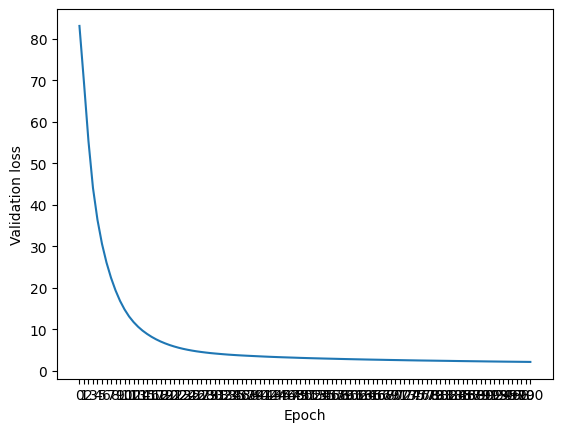

In [108]:
epoch_nums = list(range(len(validation_losses)))
plt.plot(epoch_nums, validation_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.xticks(epoch_nums)
plt.show()

**Recovering the best validation model**:

After training has completed, the [`TrainingLoop`](https://instadeepai.github.io/mlip/api_reference/training/training_loop.html) holds all the relevant information about the run. We can obtain the force field with the best validation parameters as follows:

In [109]:
best_force_field = training_loop.best_model

This force field object can now be applied in, for example, MD simulations or energy minimizations.

Furthermore, these checkpoints can of course also be **used to restart a training from a given checkpoint**. We refer to the [documentation of the I/O handler's config](https://instadeepai.github.io/mlip/api_reference/training/training_io_handling.html#mlip.training.training_io_handler.TrainingIOHandlerConfig) for more information on this.

**Saving the model to a zip file**:

We can also save the trained model in zip format. This is also the format that we provide our pre-trained models in.

In [110]:
save_model_to_zip("training/my_final_model.zip", best_force_field)

**Loading a pre-trained model**

We can also load a pre-trained model from a zip file. This is useful if you want to use a pre-trained model for inference or fine-tuning on a different dataset.

In [111]:
best_force_field = load_model_from_zip(Mace, "training/my_final_model.zip")

print("Dataset info:", best_force_field.dataset_info)

Dataset info: Atomic Energies: {'H': -723.2941604798493, 'C': -723.2941604798525, 'N': -120.54902674664157, 'O': -60.27451337332064}, Avg. num. neighbors: 16.72, Avg. r_min: 1.00, Graph cutoff distance: 5.0


## Evaluation

The model will be tested on its ability to predict the energies of new conformations
of the same molecule. However, to test the generalization
capabilities of the model, these conformations are sampled at higher temperature,
i.e., 1200 Kelvin. The test conformations are located in the
`test_public.xyz` file. You can predict energies for them with a model saved in the
zip format with the mlip library's batched inference functionality, described
[here](https://instadeepai.github.io/mlip/user_guide/simulations.html#batched-inference)
in the mlip documentation or explained in section 2 of
[mlip's simulation tutorial](https://github.com/instadeepai/mlip/blob/main/tutorials/simulation_tutorial.ipynb).
The public leaderboard contains the target energies. The metric the predictions will be scored on is root-mean-square error (RMSE).


**Hint**: to get the best energies, you want to put higher weights on energies during training which is not the case in the default settings, where forces are more highly weighted.


In [112]:
from ase.io import read as ase_read

test_data = "data/test_public.xyz"
structures = ase_read(test_data, index=":")

We can now run inference with a single pre-built function, note Jax starts by compiling all the required functions. It may appear slow at the beginning but this provides significant acceleration at scales (compilation is saved in the notebook kernel, so if you want an illustration of the speed gains, you can run the cell twice):

In [113]:
from mlip.inference import run_batched_inference

predictions = run_batched_inference(structures, best_force_field, batch_size=8)

INFO - Graphs preparation done. Now running inference on 200 structure(s) in 26 batches...
INFO - Batch 1 completed.
INFO - Batch 2 completed.
INFO - Batch 3 completed.
INFO - Batch 4 completed.
INFO - Batch 5 completed.
INFO - Batch 6 completed.
INFO - Batch 7 completed.
INFO - Batch 8 completed.
INFO - Batch 9 completed.
INFO - Batch 10 completed.
INFO - Batch 11 completed.
INFO - Batch 12 completed.
INFO - Batch 13 completed.
INFO - Batch 14 completed.
INFO - Batch 15 completed.
INFO - Batch 16 completed.
INFO - Batch 17 completed.
INFO - Batch 18 completed.
INFO - Batch 19 completed.
INFO - Batch 20 completed.
INFO - Batch 21 completed.
INFO - Batch 22 completed.
INFO - Batch 23 completed.
INFO - Batch 24 completed.
INFO - Batch 25 completed.
INFO - Batch 26 completed.


# Get your output into submission format

We need to get our outputs into their "camera-ready" form.

In [114]:
energies = np.array([prediction.energy for prediction in predictions])

# Create DataFrame
df = pd.DataFrame({
    'ID': np.arange(len(energies)),
    'energies': energies
})

df

,ID,energies
0,0,-17657.142578
1,1,-17657.601562
2,2,-17658.404297
3,3,-17658.500000
4,4,-17657.558594
...,...,...
195,195,-17658.527344
196,196,-17658.361328
197,197,-17657.376953
198,198,-17657.753906


In [115]:
your_name = "Charl_Botha"
filename = f"{your_name}_submission.csv"
df.to_csv(filename, index=False)
print(f"Saved submission to {filename}")

Saved submission to Charl_Botha_submission.csv


Submit your solution by uploading the CSV file to the [Zindi competition page](https://zindi.africa/competitions/indabax-south-africa-2025-hackathon-with-instadeep).